# Load required libs

In [1]:
%cd ..
%pwd
import sys
sys.path.append('./src')
import pandas as pd
from src.data_processor import RawDataProcessor
from src.problem_config import create_prob_config
from src.drift_detector import ks_drift_detect
prob_config = create_prob_config("phase-3", "prob-2")

c:\VENV\api_prediction


In [2]:
from mlflow.models.signature import infer_signature
import mlflow

def log_model_to_tracker(model, metrics, desc):
    MLFLOW_TRACKING_URI = 'http://192.168.88.113:5000'
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment("phase-3_prob-2_lgbm")
    MLFLOW_MODEL_PREFIX = "model"
    mlflow.start_run(description=desc)
    mlflow.log_metrics(metrics)
    mlflow.log_params(model.get_params())
    signature = infer_signature(test_x.astype(np.float64), predictions)
    mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path=MLFLOW_MODEL_PREFIX,
        signature=signature,
        pip_requirements ='src/requirements.txt'
        #registered_model_name="phase-1_prob-1_model-1"
    )

    experimentid = mlflow.active_run().info.run_id
    mlflow.end_run()
    return experimentid

# Prepare datasets

In [3]:
# Import xtran and ytrain
import pandas as pd
import numpy as np
import pickle

training_data0 = pd.read_parquet(prob_config.raw_data_path)
training_data0 = training_data0.drop_duplicates()

training_data0, category_index = RawDataProcessor.build_category_features(
            training_data0, prob_config.categorical_cols
        )

with open(prob_config.category_index_path, "wb") as f:
    pickle.dump(category_index, f)

In [4]:
unswnb15 = pd.read_csv('C:/VENV/MLOPS Competition/UNSW-NB15/UNSW_NB15_training-set.csv')
unswnb15_t = pd.read_csv('C:/VENV/MLOPS Competition/UNSW-NB15/UNSW_NB15_testing-set.csv')

def label_mod(x):
    if x in ['Exploits', 'Normal']:
        return x
    elif (x == 'DoS') or (x == 'Fuzzers'):
        return 'Denial of Service'
    elif (x == 'Reconnaissance'):
        return 'Information Gathering'
    elif (x == 'Worms') or (x == 'Shellcode'):
        return 'Malware'
    elif (x == 'Generic'):
        return 'Other'
    else:
        return np.nan
    
fets_dict = {'dur': 'feature1', 'proto': 'feature2', 'service': 'feature3', 'state': 'feature4', \
                                    'spkts': 'feature5', 'dpkts': 'feature6', 'sbytes': 'feature7', 'dbytes': 'feature8',\
                                        'sttl': 'feature9', 'dttl': 'feature10', 'sload': 'feature11', 'dload': 'feature12',\
                                            'sloss': 'feature13', 'dloss': 'feature14', 'sinpkt': 'feature15', 'dinpkt': 'feature16',\
                                                'sjit': 'feature17', 'djit': 'feature18', 'swin': 'feature19', 'stcpb': 'feature20', \
                                                    'dtcpb': 'feature21', 'dwin': 'feature22', 'tcprtt': 'feature23', 'synack': 'feature24',\
                                                        'ackdat': 'feature25', 'smean': 'feature26', 'dmean': 'feature27', 'ct_ftp_cmd': 'feature37',\
                                                            'response_body_len': 'feature29','ct_srv_src': 'feature30', 'ct_state_ttl': 'feature31', 'ct_dst_ltm': 'feature32', \
                                                                'ct_src_dport_ltm': 'feature33', 'ct_dst_sport_ltm': 'feature34', 'ct_dst_src_ltm': 'feature35',\
                                                                    'is_ftp_login': 'feature36', 'trans_depth': 'feature28', 'ct_flw_http_mthd': 'feature38', 'ct_src_ltm': 'feature39',\
                                                                    'ct_srv_dst':'feature40', 'is_sm_ips_ports':'feature41'}

unswnb15 = unswnb15.rename(columns=fets_dict)

unswnb15 = RawDataProcessor.apply_category_features(
    raw_df=unswnb15,
    categorical_cols=prob_config.categorical_cols,
    category_index=category_index,
)

# feature 20 / feature 21 (swap?)
# feature 23 / feature 24
# rate -> feature ?

unswnb15["attack_cat"] = unswnb15["attack_cat"].apply(label_mod)
unswnb15 = unswnb15.dropna()

unswnb15_t = unswnb15_t.rename(columns=fets_dict)
unswnb15_t = RawDataProcessor.apply_category_features(
    raw_df=unswnb15_t,
    categorical_cols=prob_config.categorical_cols,
    category_index=category_index,
)
unswnb15_t["attack_cat"] = unswnb15_t["attack_cat"].apply(label_mod)
unswnb15_t = unswnb15_t.dropna()


In [97]:
pd.Series(model0.predict(unswnb15_t[unswnb15_t["attack_cat"] == 'Generic'][prob_config.feature_cols])).value_counts()

5    39465
1      269
0      206
4       43
3       13
2        4
Name: count, dtype: int64

In [37]:
labels_dict

{'Denial of Service': 0,
 'Exploits': 1,
 'Information Gathering': 2,
 'Malware': 3,
 'Normal': 4,
 'Other': 5}

In [142]:
unswnb15_t = pd.read_csv('C:/VENV/MLOPS Competition/UNSW-NB15/UNSW_NB15_testing-set.csv')

In [190]:
unswnb15[unswnb15['attack_cat'] == 'Exploits']['feature9'].unique()

array([254,  62, 255,  63], dtype=int64)

In [155]:
unswnb15_t.columns

Index(['id', 'feature1', 'feature2', 'feature3', 'feature4', 'feature5',
       'feature6', 'feature7', 'feature8', 'rate', 'feature9', 'feature10',
       'feature11', 'feature12', 'feature13', 'feature14', 'feature15',
       'feature16', 'feature17', 'feature18', 'feature19', 'feature20',
       'feature21', 'feature22', 'feature23', 'feature24', 'feature25',
       'feature26', 'feature27', 'feature28', 'feature29', 'feature30',
       'feature31', 'feature32', 'feature33', 'feature34', 'feature35',
       'feature36', 'feature37', 'feature38', 'feature39', 'feature40',
       'feature41', 'attack_cat', 'label'],
      dtype='object')

<Axes: >

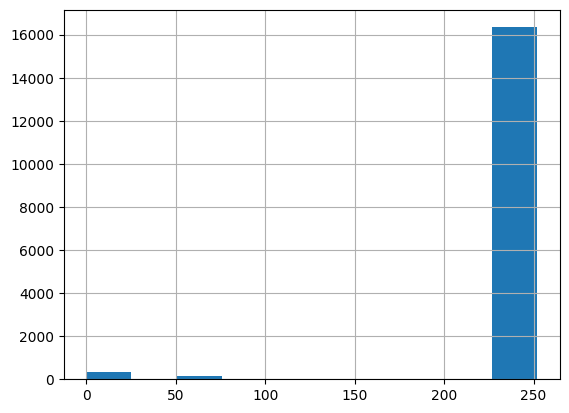

In [192]:
unswnb15_t[unswnb15_t['attack_cat'] == 'Exploits']['feature10'].hist()

In [185]:
training_data0[training_data0['label'] == 'Exploits']['feature9'].unique()

array([254.,  62.,   0.])

<Axes: >

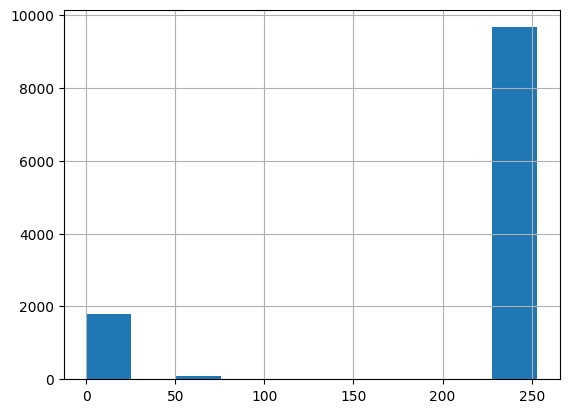

In [193]:
training_data0[training_data0['label'] == 'Exploits']['feature10'].hist()
# 29 ?

In [11]:
conflict_labels = training_data0[training_data0.duplicated(prob_config.feature_cols, keep=False)].sort_values(by=prob_config.feature_cols)
conflict_labels["org_idx"] = conflict_labels.index
data_conflict = conflict_labels.groupby(prob_config.feature_cols).agg({"org_idx": lambda x: tuple(x), "label": lambda x: tuple(x)}).reset_index()
#apply(lambda x: tuple(x.index)).to_list()

In [5]:
from sklearn.model_selection import train_test_split

training_data = training_data0
#training_data = training_data0.drop_duplicates(subset=prob_config.feature_cols, keep=False)
target_col = prob_config.target_col
train_x0 = training_data.drop([target_col], axis=1)
train_y0 = training_data[[target_col]]

train, dev = train_test_split(training_data, test_size=0.1, random_state=123)

train_x = train.drop(["label"], axis=1)
train_y = train[[target_col]]
test_x = dev.drop(["label"], axis=1)
test_y = dev[[target_col]]

In [11]:
labels_dict = {}
labels_unq = train_y0['label'].unique()
labels_unq.sort()
for i in range(len(labels_unq)):
    labels_dict[labels_unq[i]] = i

inv_labels_dict = {v: k for k, v in labels_dict.items()}
model_classes_path = prob_config.data_path / 'classes.npy'
np.save(model_classes_path, labels_unq)

In [215]:
from xgboost import XGBClassifier

model0 = XGBClassifier(objective="multi:softprob", random_state=123)
model0.fit(train_x0, train_y0.replace(labels_dict), verbose=False)#, eval_set=eval_set)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [56]:
import treelite

model = treelite.Model.from_xgboost(model0._Booster)

In [ ]:
import tl2cgen     # runtime module
tl2cgen.export_lib(model, toolchain="msvc", libpath="./mymodel.dll", params={})
predictor = tl2cgen.Predictor('./mymodel.dll', verbose=True)

In [210]:
%%timeit
predictor.predict(tl2cgen.DMatrix(test_x))

52.8 ms ± 2.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
%%timeit
model0.predict(test_x)

21.1 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
from lightgbm import LGBMClassifier

eval_set = [(train_x, train_y), (test_x, test_y)]
model0 = LGBMClassifier(objective="multiclass", random_state=123)
model0.fit(train_x0, train_y0, verbose=False)#, eval_set=eval_set)

c:\VENV\api_prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\VENV\api_prediction\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\VENV\api_prediction\.venv\Lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(objective='multiclass', random_state=123)

In [ ]:
#import lightgbm as lgb

#lgb.plot_metric(model0)

In [7]:
data22 = pd.read_parquet('data/phase-2/prob-2/raw_train.parquet')

data22 = RawDataProcessor.apply_category_features(
    raw_df=data22,
    categorical_cols=prob_config.categorical_cols,
    category_index=category_index,
)

data22.drop_duplicates(inplace=True)

In [200]:
conflict_labels2 = data22[data22.duplicated(prob_config.feature_cols, keep=False)].sort_values(by=prob_config.feature_cols)
conflict_labels2["org_idx"] = conflict_labels2.index
conflict_labels2.groupby(prob_config.feature_cols).agg({"org_idx": lambda x: tuple(x), "label": lambda x: tuple(x)}).reset_index()[["org_idx","label"]]

,org_idx,label
0,"(18610, 61207)","(Exploits, Denial of Service)"
1,"(16762, 25916, 46019)","(Denial of Service, Exploits, Information Gath..."
2,"(10701, 59138, 59472)","(Exploits, Information Gathering, Denial of Se..."
3,"(32122, 43251, 57080)","(Information Gathering, Denial of Service, Exp..."
4,"(4625, 12609, 23488, 40864)","(Malware, Denial of Service, Exploits, Informa..."
...,...,...
1659,"(2052, 12187, 56610)","(Denial of Service, Exploits, Information Gath..."
1660,"(13656, 37184, 50897)","(Exploits, Information Gathering, Denial of Se..."
1661,"(6358, 11822, 55169)","(Exploits, Denial of Service, Information Gath..."
1662,"(2594, 12669)","(Exploits, Denial of Service)"


In [48]:
from xgboost import XGBClassifier
data22.drop_duplicates(subset=prob_config.feature_cols, keep=False, inplace=True)
#unswnb15.drop_duplicates(subset=prob_config.feature_cols, keep=False, inplace=True)
#unswnb15_t.drop_duplicates(subset=prob_config.feature_cols, keep=False, inplace=True)

train_x_new = pd.DataFrame(np.concatenate((train_x0, data22[prob_config.feature_cols], unswnb15[prob_config.feature_cols], unswnb15_t[prob_config.feature_cols])), columns=train_x.columns)
train_y_new = pd.DataFrame(np.concatenate((train_y0, data22[[prob_config.target_col]], unswnb15[['attack_cat']], unswnb15_t[['attack_cat']])), columns=train_y.columns)

model2 = XGBClassifier(objective="multi:softprob", random_state=123, **automl.best_config)
#model1 = LGBMClassifier(objective="multiclass", random_state=123, num_leaves=62, n_estimators=150)
#model1 = LGBMClassifier(objective="multiclass", random_state=123, num_leaves=62, n_estimators=200)
#model1 = LGBMClassifier(objective="multiclass", random_state=123, **automl.best_config)
model2.fit(train_x_new, train_y_new.replace(labels_dict), verbose=False) #.replace(labels_dict)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.9666916141703009, colsample_bynode=None,
              colsample_bytree=0.5397808747558309, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.9302405288798644,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=704,
              min_child_weight=0.001, missing=nan, monotone_constraints=None,
              n_estimators=114, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [52]:
from sklearn.metrics import accuracy_score
predictions = model2.predict(test_x)
#predictions = s.predict_model(best[0], data = test_x)["prediction_label"]
accuracy = accuracy_score(predictions, test_y.replace(labels_dict))
metrics = {"accuracy_score": accuracy}
print(f"metrics: {metrics}")

metrics: {'accuracy_score': 0.9111963190184049}


In [53]:
accuracy_score(model2.predict(unswnb15_t[prob_config.feature_cols]), unswnb15_t['attack_cat'].replace(labels_dict))

0.8885923249511932

In [54]:
data22.drop_duplicates(subset=prob_config.feature_cols, keep=False, inplace=True)
accuracy_score(model2.predict(training_data.drop([target_col], axis=1)), training_data[[target_col]].replace(labels_dict))

0.9096807841573223

In [44]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy', 
    "estimator_list": ['xgboost'],#lgbm
                        # check the documentation for options of metrics (https://microsoft.github.io/FLAML/docs/Use-Cases/Task-Oriented-AutoML#optimization-metric)
    "task": 'classification',  # task type
    "log_file_name": 'prob2_experiment.log',  # flaml log file
    "seed": 123,    # random seed
}

automl.fit(X_train=train_x_new, y_train=train_y_new.replace(labels_dict)['label'], **settings)

[flaml.automl.logger: 08-23 20:31:21] {1679} INFO - task = classification
[flaml.automl.logger: 08-23 20:31:21] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 08-23 20:31:22] {1788} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 08-23 20:31:22] {1900} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 08-23 20:31:22] {2218} INFO - iteration 0, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:23] {2344} INFO - Estimated sufficient time budget=144744s. Estimated necessary time budget=145s.
[flaml.automl.logger: 08-23 20:31:23] {2391} INFO -  at 4.2s,	estimator xgboost's best error=0.2273,	best estimator xgboost's best error=0.2273
[flaml.automl.logger: 08-23 20:31:23] {2218} INFO - iteration 1, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:23] {2391} INFO -  at 4.6s,	estimator xgboost's best error=0.2146,	best estimator xgboost's best error=0.2146
[flaml.automl.logger: 08-23 20:31:23] {2218} INFO - iteration 2, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:24] {2391} INFO -  at 4.9s,	estimator xgboost's best error=0.2146,	best estimator xgboost's best error=0.2146
[flaml.automl.logger: 08-23 20:31:24] {2218} INFO - iteration 3, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:24] {2391} INFO -  at 5.3s,	estimator xgboost's best error=0.2146,	best estimator xgboost's best error=0.2146
[flaml.automl.logger: 08-23 20:31:24] {2218} INFO - iteration 4, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:25] {2391} INFO -  at 6.1s,	estimator xgboost's best error=0.1761,	best estimator xgboost's best error=0.1761
[flaml.automl.logger: 08-23 20:31:25] {2218} INFO - iteration 5, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:25] {2391} INFO -  at 6.4s,	estimator xgboost's best error=0.1761,	best estimator xgboost's best error=0.1761
[flaml.automl.logger: 08-23 20:31:25] {2218} INFO - iteration 6, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:26] {2391} INFO -  at 7.8s,	estimator xgboost's best error=0.1761,	best estimator xgboost's best error=0.1761
[flaml.automl.logger: 08-23 20:31:26] {2218} INFO - iteration 7, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:27] {2391} INFO -  at 8.5s,	estimator xgboost's best error=0.1723,	best estimator xgboost's best error=0.1723
[flaml.automl.logger: 08-23 20:31:27] {2218} INFO - iteration 8, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:28] {2391} INFO -  at 9.2s,	estimator xgboost's best error=0.1723,	best estimator xgboost's best error=0.1723
[flaml.automl.logger: 08-23 20:31:28] {2218} INFO - iteration 9, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:28] {2391} INFO -  at 9.9s,	estimator xgboost's best error=0.1723,	best estimator xgboost's best error=0.1723
[flaml.automl.logger: 08-23 20:31:28] {2218} INFO - iteration 10, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:29] {2391} INFO -  at 10.5s,	estimator xgboost's best error=0.1723,	best estimator xgboost's best error=0.1723
[flaml.automl.logger: 08-23 20:31:29] {2218} INFO - iteration 11, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:30] {2391} INFO -  at 11.8s,	estimator xgboost's best error=0.1723,	best estimator xgboost's best error=0.1723
[flaml.automl.logger: 08-23 20:31:30] {2218} INFO - iteration 12, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:32] {2391} INFO -  at 13.4s,	estimator xgboost's best error=0.1618,	best estimator xgboost's best error=0.1618
[flaml.automl.logger: 08-23 20:31:32] {2218} INFO - iteration 13, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:33] {2391} INFO -  at 14.4s,	estimator xgboost's best error=0.1618,	best estimator xgboost's best error=0.1618
[flaml.automl.logger: 08-23 20:31:33] {2218} INFO - iteration 14, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:36] {2391} INFO -  at 17.6s,	estimator xgboost's best error=0.1618,	best estimator xgboost's best error=0.1618
[flaml.automl.logger: 08-23 20:31:36] {2218} INFO - iteration 15, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:38] {2391} INFO -  at 19.1s,	estimator xgboost's best error=0.1575,	best estimator xgboost's best error=0.1575
[flaml.automl.logger: 08-23 20:31:38] {2218} INFO - iteration 16, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:39] {2391} INFO -  at 20.2s,	estimator xgboost's best error=0.1575,	best estimator xgboost's best error=0.1575
[flaml.automl.logger: 08-23 20:31:39] {2218} INFO - iteration 17, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:40] {2391} INFO -  at 21.3s,	estimator xgboost's best error=0.1575,	best estimator xgboost's best error=0.1575
[flaml.automl.logger: 08-23 20:31:40] {2218} INFO - iteration 18, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:42] {2391} INFO -  at 23.2s,	estimator xgboost's best error=0.1575,	best estimator xgboost's best error=0.1575
[flaml.automl.logger: 08-23 20:31:42] {2218} INFO - iteration 19, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:44] {2391} INFO -  at 25.7s,	estimator xgboost's best error=0.1571,	best estimator xgboost's best error=0.1571
[flaml.automl.logger: 08-23 20:31:44] {2218} INFO - iteration 20, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:46] {2391} INFO -  at 27.1s,	estimator xgboost's best error=0.1571,	best estimator xgboost's best error=0.1571
[flaml.automl.logger: 08-23 20:31:46] {2218} INFO - iteration 21, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:50] {2391} INFO -  at 31.8s,	estimator xgboost's best error=0.1571,	best estimator xgboost's best error=0.1571
[flaml.automl.logger: 08-23 20:31:50] {2218} INFO - iteration 22, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:52] {2391} INFO -  at 33.3s,	estimator xgboost's best error=0.1559,	best estimator xgboost's best error=0.1559
[flaml.automl.logger: 08-23 20:31:52] {2218} INFO - iteration 23, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:53] {2391} INFO -  at 34.2s,	estimator xgboost's best error=0.1559,	best estimator xgboost's best error=0.1559
[flaml.automl.logger: 08-23 20:31:53] {2218} INFO - iteration 24, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:55] {2391} INFO -  at 36.5s,	estimator xgboost's best error=0.1559,	best estimator xgboost's best error=0.1559
[flaml.automl.logger: 08-23 20:31:55] {2218} INFO - iteration 25, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:31:57] {2391} INFO -  at 37.9s,	estimator xgboost's best error=0.1559,	best estimator xgboost's best error=0.1559
[flaml.automl.logger: 08-23 20:31:57] {2218} INFO - iteration 26, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:32:00] {2391} INFO -  at 41.1s,	estimator xgboost's best error=0.1559,	best estimator xgboost's best error=0.1559
[flaml.automl.logger: 08-23 20:32:00] {2218} INFO - iteration 27, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:32:03] {2391} INFO -  at 44.1s,	estimator xgboost's best error=0.1395,	best estimator xgboost's best error=0.1395
[flaml.automl.logger: 08-23 20:32:03] {2218} INFO - iteration 28, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:32:05] {2391} INFO -  at 46.3s,	estimator xgboost's best error=0.1395,	best estimator xgboost's best error=0.1395
[flaml.automl.logger: 08-23 20:32:05] {2218} INFO - iteration 29, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:32:09] {2391} INFO -  at 50.8s,	estimator xgboost's best error=0.1385,	best estimator xgboost's best error=0.1385
[flaml.automl.logger: 08-23 20:32:09] {2218} INFO - iteration 30, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:32:26] {2391} INFO -  at 67.0s,	estimator xgboost's best error=0.0948,	best estimator xgboost's best error=0.0948
[flaml.automl.logger: 08-23 20:32:26] {2218} INFO - iteration 31, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:32:30] {2391} INFO -  at 71.9s,	estimator xgboost's best error=0.0948,	best estimator xgboost's best error=0.0948
[flaml.automl.logger: 08-23 20:32:30] {2218} INFO - iteration 32, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:33:07] {2391} INFO -  at 108.8s,	estimator xgboost's best error=0.0948,	best estimator xgboost's best error=0.0948
[flaml.automl.logger: 08-23 20:33:07] {2218} INFO - iteration 33, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:33:17] {2391} INFO -  at 118.7s,	estimator xgboost's best error=0.0948,	best estimator xgboost's best error=0.0948
[flaml.automl.logger: 08-23 20:33:17] {2218} INFO - iteration 34, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:33:55] {2391} INFO -  at 156.1s,	estimator xgboost's best error=0.0948,	best estimator xgboost's best error=0.0948
[flaml.automl.logger: 08-23 20:33:55] {2218} INFO - iteration 35, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:34:04] {2391} INFO -  at 165.3s,	estimator xgboost's best error=0.0948,	best estimator xgboost's best error=0.0948
[flaml.automl.logger: 08-23 20:34:04] {2218} INFO - iteration 36, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:35:04] {2391} INFO -  at 225.0s,	estimator xgboost's best error=0.0938,	best estimator xgboost's best error=0.0938
[flaml.automl.logger: 08-23 20:35:04] {2218} INFO - iteration 37, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:35:18] {2391} INFO -  at 239.8s,	estimator xgboost's best error=0.0938,	best estimator xgboost's best error=0.0938
[flaml.automl.logger: 08-23 20:35:18] {2218} INFO - iteration 38, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:35:59] {2391} INFO -  at 280.2s,	estimator xgboost's best error=0.0938,	best estimator xgboost's best error=0.0938
[flaml.automl.logger: 08-23 20:35:59] {2218} INFO - iteration 39, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:37:07] {2391} INFO -  at 348.1s,	estimator xgboost's best error=0.0938,	best estimator xgboost's best error=0.0938
[flaml.automl.logger: 08-23 20:37:07] {2218} INFO - iteration 40, current learner xgboost


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:40:45] {2391} INFO -  at 566.8s,	estimator xgboost's best error=0.0938,	best estimator xgboost's best error=0.0938


c:\VENV\api_prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[flaml.automl.logger: 08-23 20:41:50] {2627} INFO - retrain xgboost for 64.2s
[flaml.automl.logger: 08-23 20:41:50] {2630} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.9666916141703009, colsample_bynode=None,
              colsample_bytree=0.5397808747558309, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.9302405288798644, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=704,
              min_child_weight=0.001, missing=nan, monotone_constraints=None,
              n_estimators=114, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)
[flaml.automl.logger: 08-23 20:41:50

In [46]:
''' retrieve best config'''
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best hyperparmeter config: {'n_estimators': 114, 'max_leaves': 704, 'min_child_weight': 0.001, 'learning_rate': 0.9302405288798644, 'subsample': 1.0, 'colsample_bylevel': 0.9666916141703009, 'colsample_bytree': 0.5397808747558309, 'reg_alpha': 0.046581678912992294, 'reg_lambda': 1.4676351278995305}
Best accuracy on validation data: 0.9062
Training duration of best run: 64.16 s


In [59]:
run_description = """
### Header
XGB model
Model: XGB (Using UNSW NB-15)
    """
log_model_to_tracker(model2, metrics, run_description)

2023-08-23 21:05:55,346 - Retrying (Retry(total=4, connect=4, read=5, redirect=5, status=5)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D481FF5D50>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=phase-3_prob-2_lgbm
2023-08-23 21:06:01,681 - Retrying (Retry(total=3, connect=3, read=5, redirect=5, status=5)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D481FF5F10>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it')': /api/2.0/mlflow/experiments/get-by-name?experiment_name=phase-3_prob-2_lgbm
2023-08-23 21:06:11,996 - Retrying (Retry(total=2, connect=2, read=5, redirect=5, status=5)) after connection broken by 'NewConnectionError('<urllib3.connection.HTTPC

MlflowException: API request to http://192.168.88.113:5000/api/2.0/mlflow/experiments/get-by-name failed with exception HTTPConnectionPool(host='192.168.88.113', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=phase-3_prob-2_lgbm (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001D481D5C690>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [41]:
mlflow.end_run()

In [35]:
import lleaves
model_path = ".venv/phase2_2_lgbm.txt"
model1.booster_.save_model(filename=model_path)
llvm_model = lleaves.Model(model_file=model_path)
llvm_model.compile()

In [37]:
%%timeit -n 10
z = llvm_model.predict(test_x)
labels = np.argmax(z, axis=1)
classes = model0.classes_
labels = [classes[i] for i in labels]

53.2 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
%%timeit -n 10
model2.predict(test_x)

38.1 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Drift Detection 

In [10]:
# Save referent for drift detection.
X_baseline = train_x0.sample(1000)
X_baseline_df = pd.DataFrame(X_baseline, columns=prob_config.drift_cols)
X_baseline_df.to_parquet(prob_config.driff_ref_path, index=False)

# Model drift

In [195]:
import pandas as pd
import redis
import pickle
# Load data for problem 1
rc2 = redis.Redis(host='192.168.88.113', db=2, port=6379)

captured_x = pd.DataFrame()
for key in rc2.keys():
    captured_data = pickle.loads(rc2.get(key))
    captured_x = pd.concat([captured_x, captured_data])

captured_x.drop_duplicates(inplace=True, ignore_index=True)

captured_x = RawDataProcessor.apply_category_features(
    raw_df=captured_x[train_x0.columns],
    categorical_cols=prob_config.categorical_cols,
    category_index=category_index,
)

In [66]:
import redis
rc2 = redis.Redis(host='192.168.88.113', db=2, port=6379)
rc2.flushdb()

True

In [69]:
len(rc2.keys())

1

In [128]:
#np_captured_x = np_captured_x.astype(train_x.dtypes.to_dict())

In [334]:
from sklearn.cluster import MiniBatchKMeans
import joblib
import numpy as np
# N là số lượng cluster
N = 30000
# Train clustering model cho data đã có label
kmeans = MiniBatchKMeans(n_clusters=N, random_state=0, n_init='auto').fit(train_x0)
joblib.dump(kmeans, 'data/phase-3/prob-2/kmeans.cpk')

['data/phase-3/prob-2/kmeans.cpk']

In [336]:
import joblib
import numpy as np

N = 30000
kmeans = joblib.load('data/phase-3/prob-2/kmeans.cpk')
new_labels = []

# Duyệt từng cluster
for  i  in  range(N):
	# Lấy các label của các data point thuộc cluster i
	mask = (kmeans.labels_ == i)
	cluster_labels = train_y0[mask]

	if  len(cluster_labels) == 0:
		# Nếu cluster i rỗng thì xác định cluster i ánh xạ với 1 label mặc định (ở đây lựa chọn là 0)
		new_labels.append(np.nan)
	else:
		# Tìm label mới cho cả cụm cluster trong trường hợp cụm cluster khác rỗng
		#if  isinstance(train_y.flatten()[0], float):
			# Nếu là bài toán Regression thì lấy giá trị trung bình của các label thuộc cluster
		#	new_labels.append(np.mean(cluster_labels.flatten()))
		#else:
			# Nếu là bài toán Classification thì lấy label xuất hiện nhiều nhất trong cluster
			new_labels.append(cluster_labels.value_counts().idxmax()[0])

# Ánh xạ lại label cho data drift dựa trên kết quả predict cluster ở trên
y_drift_propagated = [new_labels[c] for  c  in  kmeans.labels_]

In [338]:
y_drift_test_propagated = [ new_labels[c] for c in kmeans.predict(test_x)]
from sklearn.metrics import accuracy_score
accuracy_score(y_drift_test_propagated, test_y)

0.6230322518717604

In [ ]:
fix_label_kmean = []
for i in range(len(y_drift_test_propagated)):
    if y_drift_test_propagated[i] in data_conflict['label'][i]:
        fix_label_kmean.append(y_drift_test_propagated[i])
    else:
        fix_label_kmean.append(np.nan)

In [242]:
newdata = data_conflict[prob_config.feature_cols]
newdata['label'] = fix_label_kmean

C:\Users\buikh\AppData\Local\Temp\ipykernel_7700\2891075784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newdata['label'] = fix_label_kmean


In [346]:
captured_x['label'] = [ new_labels[c] for c in kmeans.predict(captured_x[prob_config.feature_cols])]
captured_x.dropna(inplace=True)

train_x_new = pd.DataFrame(np.concatenate((train_x0, captured_x[prob_config.feature_cols])), columns=train_x.columns)
train_y_new = pd.DataFrame(np.concatenate((train_y0, captured_x[[prob_config.target_col]])), columns=train_y.columns)

model2 = XGBClassifier(objective="multi:softprob", random_state=123)
#LGBMClassifier(objective="binary", random_state=123, is_unbalance=True)
model2.fit(train_x_new, train_y_new.replace(labels_dict), verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [356]:
accuracy_score(model2.predict(test_x), test_y.replace(labels_dict))

0.92

In [353]:
accuracy_score(model2.predict(captured_x[prob_config.feature_cols]), captured_x[[prob_config.target_col]].replace(labels_dict))

0.7651180248561181

In [355]:
accuracy_score(model2.predict(captured_x[prob_config.feature_cols]), model1.predict(captured_x[prob_config.feature_cols].replace(labels_dict)))

0.8501960130119276

# Backup code

```
conflict_labels = data_conflict['label']
proba_fix = pd.DataFrame(model0.predict_proba(data_conflict[prob_config.feature_cols]), columns=labels_unq)
fix_label = []
for i in range(len(conflict_labels)):
     labels = conflict_labels[i]
     fix_label.append(labels[proba_fix[list(labels)].iloc[i].argmax()])

fix_label = pd.DataFrame(fix_label)

train_x_new = pd.DataFrame(np.concatenate((train_x0, data_conflict[prob_config.feature_cols])), columns=train_x.columns)
train_y_new = pd.DataFrame(np.concatenate((train_y0, fix_label)), columns=train_y.columns)

model1 = XGBClassifier(objective="multi:softprob", random_state=123)
#LGBMClassifier(objective="binary", random_state=123, is_unbalance=True)
model1.fit(train_x_new, train_y_new.replace(labels_dict), verbose=False) ```